# **Proyecto 4: Faces in The Wild**
---

**Integrantes**:
- Lucas Carranza
- David Herencia
- Kalos Lazo
- Lenin Chavez

---

## **1. Librerías**

In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import math

from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torchvision import transforms, datasets

---
## **2. Configuración de cuda**

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f"Device: {device}")

Device: cpu


---
## **3. Funciones generales**

A continuación se define funciones generales encapsuladas en clases de ser necesario para mejorar la eficiencia del desarrollo de nuestro modelo, por ejemplo `ImageHandler` es una clase que alberga clases para poder interactuar con las imagenes de forma sencilla.

In [56]:
class ImageHandler:
    def __init__(self, image_path = "cropped_faces"):
        self.image_path = image_path

    def load_img(self, img_id):
        path = f"{self.image_path}/{img_id}.png"
        return Image.open(path)

    def plot_imgs(self, imgs, size = 3):
        img_number = imgs.shape[0]
        rows = cols = math.ceil(np.sqrt(img_number))
        fig = plt.figure(figsize=(rows*size, cols*size))
        for i in range(img_number):
            fig.add_subplot(rows, cols, i+1)
            plt.imshow(imgs[i])
            plt.axis('off')
        plt.show()

    def visualize_samples(self, loader, num_samples = 5, size = 3):
        rows = cols = math.ceil(np.sqrt(num_samples))
        fig = plt.figure(figsize = (rows*size, cols*size))
        for images1, images2, labels in loader:
            for i in range(num_samples):
                plt.subplot(rows, cols, i+1)
                image = images1[i].permute(1, 2, 0).cpu().numpy()  # Change (C, H, W) to (H, W, C) and convert to numpy array
                plt.imshow(image)
                plt.axis('off')
            break
        plt.show()

---
## **3. Exploración del Dataset**

Procedemos a leer la información obtenida de nuestro dataset, de tal forma que nos encontramos con las columnas `image1_image2` y `label` que contienen el identificador de ambas imágenes a comparar y `label` para indicar si provienen del mismo rostro ó de distintos.

In [23]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print('> Train data before image splitting and label encoder');
print(train_df.head())

print('\n> Test data before image splitting and label encoder');
print(test_df.head())

> Train data before image splitting and label encoder
  image1_image2 label
0     1485_4047  diff
1     5335_6055  same
2    10796_3696  same
3    11991_6672  same
4     7003_2539  same

> Test data before image splitting and label encoder
  image1_image2
0     6874_1599
1   11365_12931
2    10132_4581
3    4706_12001
4     3350_8318


Ahora notamos que nos conviene separar `image1_image2` en dos columnas distintas, de tal forma que podamos actuar con ellas de manera independiente, además de modificar el `label` para adoptar una tecnología de codificación, tal que para `diff` usemos $0$ y para `same` el valor de $1$ representando diferencia e igualdad respectivamente.   

In [25]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df[['image1', 'image2']] = train_df['image1_image2'].str.split('_', expand = True)
test_df[['image1', 'image2']] = test_df['image1_image2'].str.split('_', expand = True)

train_df.drop(columns = ['image1_image2'], inplace = True)
test_df.drop(columns = ['image1_image2'], inplace = True)

train_df = train_df[['image1', 'image2', 'label']]
train_df['label'] = pd.factorize(train_df['label'])[0]

In [37]:
print('> Train data before image splitting and label encoder');
print(train_df.head())

print('\n> Test data before image splitting and label encoder');
print(test_df.head())

> Train data before image splitting and label encoder
  image1 image2  label
0   1485   4047      0
1   5335   6055      1
2  10796   3696      1
3  11991   6672      1
4   7003   2539      1

> Test data before image splitting and label encoder
  image1 image2
0   6874   1599
1  11365  12931
2  10132   4581
3   4706  12001
4   3350   8318


Ahora vamos a indagar más a fondo en nuestro dataset para hallar métricas útiles en nuestra implementación, a pesar que contamos con pocos datos disponibles. Es así entonces que nuestro dataset de entrenamiento cuenta con $1100$ entradas para un label $0$ y $1$ mostrando un porcentaje balanceado dado pues que el dataset en total contiene $2200$ entradas. 

In [53]:
print(f'\n> Train data shape: {train_df.shape}')
print(f'> Test data shape: {train_df.shape}')

print('\n> Train data labels with 0:', train_df['label'].value_counts()[0])
print('> Train data labels with 1:', train_df['label'].value_counts()[1])

print('\n> Train data null values:', train_df.isnull().sum().sum())
print('> Test data null values:', test_df.isnull().sum().sum())


> Train data shape: (2200, 3)
> Test data shape: (2200, 3)

> Train data labels with 0: 1100
> Train data labels with 1: 1100

> Train data null values: 0
> Test data null values: 0


Por último, se procede a brindar un claro ejemplo de cómo se vería nuestra función de tratamiento de imágenes generales `ImageHandler()` cargando dos imágenes de nuestra base de datos en un caso donde existe similitud dado por el identificado $1347$. Para este caso nuestra imagen tiene un tamaño de `64x64` con $3$ canales.

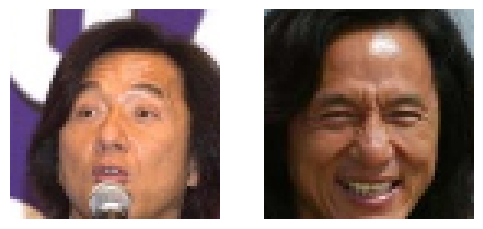

(64, 64, 3)

In [59]:
ih = ImageHandler()

im1 = ih.load_img(train_df['image1'][1347])
im2 = ih.load_img(train_df['image2'][1347])

ih.plot_imgs(np.array([im1, im2]))
np.array(im1).shape

---
## **Modelo 1: Siamese CNN**

### Data Loader for Siamese CNN

Debido a que la Red Neuronal Convolucional requiere de 2 entradas de imagenes para validar si corresponden a la misma persona o no, requerimos de un Dataset personalizado, donde la entrada consista en 2 imagenes y un label. Es por esto que creamos la clase `TwoImageDataset` a partir de la clase `Dataset` de pytorch, la cual puede obtener todos los pares de imágenes y cargarlos de dos en dos junto con el label que nos indican si son la misma persona o no.

In [ ]:
class TwoImageDataset(Dataset):
    def __init__(self, df, transform=None, is_test=False):
        self.df = df
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img1_id = self.df.iloc[idx, 0]
        img2_id = self.df.iloc[idx, 1]

        img1 = load_img(img1_id).convert('RGB')
        img2 = load_img(img2_id).convert('RGB')
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        if self.is_test:
            return img1, img2
            
        label = self.df.iloc[idx, 2]
        return img1, img2, torch.tensor(label, dtype=torch.float32)

In [ ]:
batch_size = 64
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with Image stats
])

# Train-Test split
from sklearn.model_selection import train_test_split
train_subset_df, val_subset_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# Initializing custom datasets
train_dataset = TwoImageDataset(train_subset_df, transform=transform)
val_dataset = TwoImageDataset(val_subset_df, transform=transform)
test_dataset = TwoImageDataset(test_df, transform=transform, is_test=True)

# Initialize the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Example to check the dataloader
visualize_samples(train_dataloader, 4)

In [ ]:
class SiameseCNN(nn.Module):
    def __init__(self):
        super(SiameseCNN, self).__init__()

        # self.conv1 = nn.Sequential(
        #     nn.Conv2d(3, 64, kernel_size=7, padding=3), #100
        #     nn.ReLU(),
        #     nn.Conv2d(64, 64, kernel_size=5, padding=2), #100
        #     nn.ReLU(),
        #     nn.Conv2d(64, 64, kernel_size=3, padding=1), #100
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2), #50
            
        #     nn.Conv2d(64, 128, kernel_size=7, padding=3), #50
        #     nn.ReLU(),
        #     nn.Conv2d(128, 128, kernel_size=5, padding=2), #50
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        #     nn.Conv2d(128, 128, kernel_size=3, padding=1), #50
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2), #25

        #     nn.Dropout(0.1),
            
        #     nn.Conv2d(128, 256, kernel_size=3, padding=1), #25
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(),
        #     nn.Conv2d(256, 256, kernel_size=3, padding=1), #25
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2), #12

        #     nn.Dropout(0.1),
            
        #     nn.Conv2d(256, 512, kernel_size=3, padding=1), #12
        #     nn.ReLU(),
        #     nn.Conv2d(512, 512, kernel_size=3, padding=1), #12
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2), #6
            
        #     nn.Dropout(0.1),
        # )

        from torchvision import models
        alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
        self.conv1 = nn.Sequential(*list(alexnet.children())[:-1])

        self.fc = nn.Sequential(
            nn.Linear(256*6*6 * 2, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        return x

    def forward(self, img1, img2):
        out1 = self.forward_once(img1)
        out2 = self.forward_once(img2)
        # print(out1.shape)
        
        concat = torch.cat((out1, out2), 1)
        # print(concat.shape)
        
        output = self.fc(concat)
        output = torch.flatten(output)
        # print(output)
        return output

    def train_cnn(self, train_loader, loss_fn, optimizer, scheduler=None, num_epochs=5):
        total_step = len(train_loader)
        list_loss = []
        for epoch in range(num_epochs):
            model.train()
            for i, (images1, images2, labels) in enumerate(train_loader):
                images1 = images1.to(device)
                images2 = images2.to(device)
                labels = labels.to(device)
    
                output = self(images1, images2)
                loss = loss_fn(output, labels)
    
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
                list_loss.append(loss.item())
                i += 1
    
                if (i + 1) % 10 == 0:
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {}'
                          .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

            if scheduler:
                scheduler.step()
    
        print('Finished Training Trainset')
        return list_loss
    
    def predict(self, dataloader, with_labels=False):
        y_pred = []
        model.eval()
        with torch.no_grad():
            if not with_labels:
                for image1, image2 in dataloader:
                    image1, image2 = image1.to(device), image2.to(device)
                    output = self(image1, image2)
                    output = output.cpu()
                    pred = torch.round(output)
                    y_pred.append(int(pred.item()))
            else:
                for image1, image2, _ in dataloader:
                    image1, image2 = image1.to(device), image2.to(device)
                    output = self(image1, image2)
                    output = output.cpu()
                    pred = torch.round(output)
                    y_pred.append(int(pred.item()))
            return y_pred

In [ ]:
learning_rate = 0.0001
model = SiameseCNN().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer=optimizer, step_size=2, gamma=0.1)

In [ ]:
torch.cuda.empty_cache()
epochs = 24
list_loss = model.train_cnn(train_dataloader, loss_fn, optimizer, scheduler=scheduler, num_epochs=epochs)

In [ ]:
# Plot the loss function
plt.figure(figsize=(10, 5))
plt.plot(list_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

val_pred = model.predict(val_dataloader, with_labels=True)
cm = confusion_matrix(val_subset_df['label'], val_pred, normalize='true')

# Generate the classification report
report = classification_report(val_subset_df['label'], val_pred)
print("Classification Report:")
print(report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['different', 'same'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test_values = model.predict(test_dataloader)
print(np.unique(test_values))

## Modelo 2: ??

## Experimentación

## Testing